# Настройка среды

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../../.."))

In [2]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from elements.abstracts import AbstractModulator
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from elements.simple import AdjustSize, IntensityToAmplitude, AmplitudeToIntensity
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
import torch
import torchvision
import numpy
import timm
import pandas
import optuna
from copy import deepcopy
from cluster import train, confusion, execute, epochs, SelectedGPUs
from PIL import Image
from itertools import product

In [3]:
FontLibrary.Fonts.PlotTitle.FontSize = 16

FontLibrary.Fonts.DescriptionLeft.FontSize = 12
FontLibrary.Fonts.DescriptionLeft.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionLeft.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionBottom.FontSize = 10
FontLibrary.Fonts.DescriptionBottom.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionBottom.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionTop.FontSize = 10
FontLibrary.Fonts.DescriptionTop.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionTop.FontStyle = 'italic'

FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FontLibrary.Fonts.AxisX.FontSize = 8
FontLibrary.Fonts.AxisY.FontSize = 8

FontLibrary.Fonts.GraphTitle.FontSize = 10

FigureWidthHeight = (6.69291, 10.1181-1.0)

In [4]:
device = torch.device(2 if torch.cuda.is_available() else 'cpu')
print('Используемый девайс:', torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'ЦП')

Используемый девайс: NVIDIA A100-SXM4-80GB


# Подготовка модели и данных

In [5]:
# Предпочтительные параметры
size = 2.0E-6 #2.0E-6
near_N = 8000 #8000 #2004 #1336
near_length = 16.0E-3
wavelength = 500.0E-9
distance = 50.0E-3
masks_amount = 1

# Параметры обучения
batch_size = 32//8
epochs_count = 10

# Вычисляемые параметры
pixels = closest_integer(near_length/size)
length = pixels * size
cppp = int(near_N * size / length)
N = closest_integer(length*cppp / size)

print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(length/pixels, 'м')}")
print(f"Расстояние между слоями:                  {engineering(distance, 'м')}")
print(f"Размер батча:                             {batch_size}")
print(f"Кол-во эпох:                              {epochs_count}")
print(f"Отношения пикселя к длине волны:          {round(length/(N*wavelength))}")

Длинна волны:                             500.0 нм
Количество вычислительных пикселей:       8000
Количество пикселей маски:                8000
Размер оптических элементов:              16.0 мм
Размер пикселя маски:                     2.0 мкм
Расстояние между слоями:                  50.0 мм
Размер батча:                             4
Кол-во эпох:                              10
Отношения пикселя к длине волны:          4


In [6]:
propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, 0.4)
phase_modulators = [PhaseModulator(N, length, pixels) for i in range(masks_amount)]
amplitude_modulators = [AmplitudeModulator(N, length, pixels) for i in range(masks_amount)]
elements = [propagation]
for phase_modulator, amplitude_modulator in zip(phase_modulators, amplitude_modulators):
    elements += [phase_modulator, amplitude_modulator, propagation]
    
spectral_filter = Window(centers=wavelength, sizes=300.0E-9)
detectors_filter = Gaussian((length/50, length/50), (0,0), normalization='maximum')
values = detectors_filter(torch.linspace(-length/10,+length/10,101), torch.linspace(-length/10,+length/10,101))

detectors = ClassificationDetectors(N, length, wavelength, 10, detectors_filter, spectral_filter)
detectors.normalization.integral()
model = CompositeModel(IntensityToAmplitude(), *elements, AmplitudeToIntensity(), detectors)
dataset = Dataset('MNIST', batch_size, N, N, torch.float32, threads=8, preload=10)

# Тренировка модели

In [7]:
mh, lh, cmh = [], [], []
torch.cuda.empty_cache()
mh, lh, cmh = epochs(epochs_count, 10, model, dataset, MseCrossEntropyCombination(0.3), torch.optim.Adam, lr=0.001)
# from pickle import load
# with open("../../../cluster/cash/checkpoints.pkl", 'rb') as file:
#     data = load(file)
# mh, lh, cmh = data
# print(len(cmh))
# print(f"Accuracy is {100 * numpy.sum(numpy.diagonal(cmh[-1], 0)) / numpy.sum(cmh[-1])}")
# print(mh[-1].element(0).pixels.input.x)

Training main thread PID is: 1080712
100%|███████████████████████████████████████| 1875/1875 [18:57<00:00,  1.65it/s]
Accuracy in the beginning is 11.776666666666667
RL:758.602·10⁻³, RPI1K:-621.89·10⁻⁶: 100%|████████ | 1875/1875 | 21:04m - 00:00m
 63%|████████████████████████▌              | 1181/1875 [12:05<06:46,  1.71it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



# Результаты

In [22]:
for confusion_matrix in cmh:
    print(f"Accuracy is {100 * numpy.sum(numpy.diagonal(confusion_matrix, 0)) / numpy.sum(confusion_matrix)}")

Accuracy is 11.776666666666667
Accuracy is 16.95
Accuracy is 12.715
Accuracy is 13.6
Accuracy is 15.446666666666667
Accuracy is 17.605
Accuracy is 20.048333333333332
Accuracy is 22.458333333333332
Accuracy is 24.936666666666667
Accuracy is 27.183333333333334
Accuracy is 28.640488607721956


In [8]:
model = mh[-1]
loss_history = numpy.stack(lh)[0]
confusion_matrix = cmh[-1]

In [9]:
examples = 8
dataset = Dataset('MNIST', 1, N, N, torch.float32)

In [10]:
torch.cuda.empty_cache()
model = model.to(device)

examples_images = []
examples_optical_results = []
examples_detectors_results = []

with torch.no_grad():
    for (image, result), num in zip(dataset.test, range(examples)):
        examples_images.append(image)
        image = image.to(device)
        optical_results = model.forward(image, elements=masks_amount*3+2)
        examples_optical_results.append(optical_results.cpu())
        examples_detectors_results.append(model.element(masks_amount*3+3).forward(optical_results).cpu())
        
model.cpu()
torch.cuda.empty_cache()

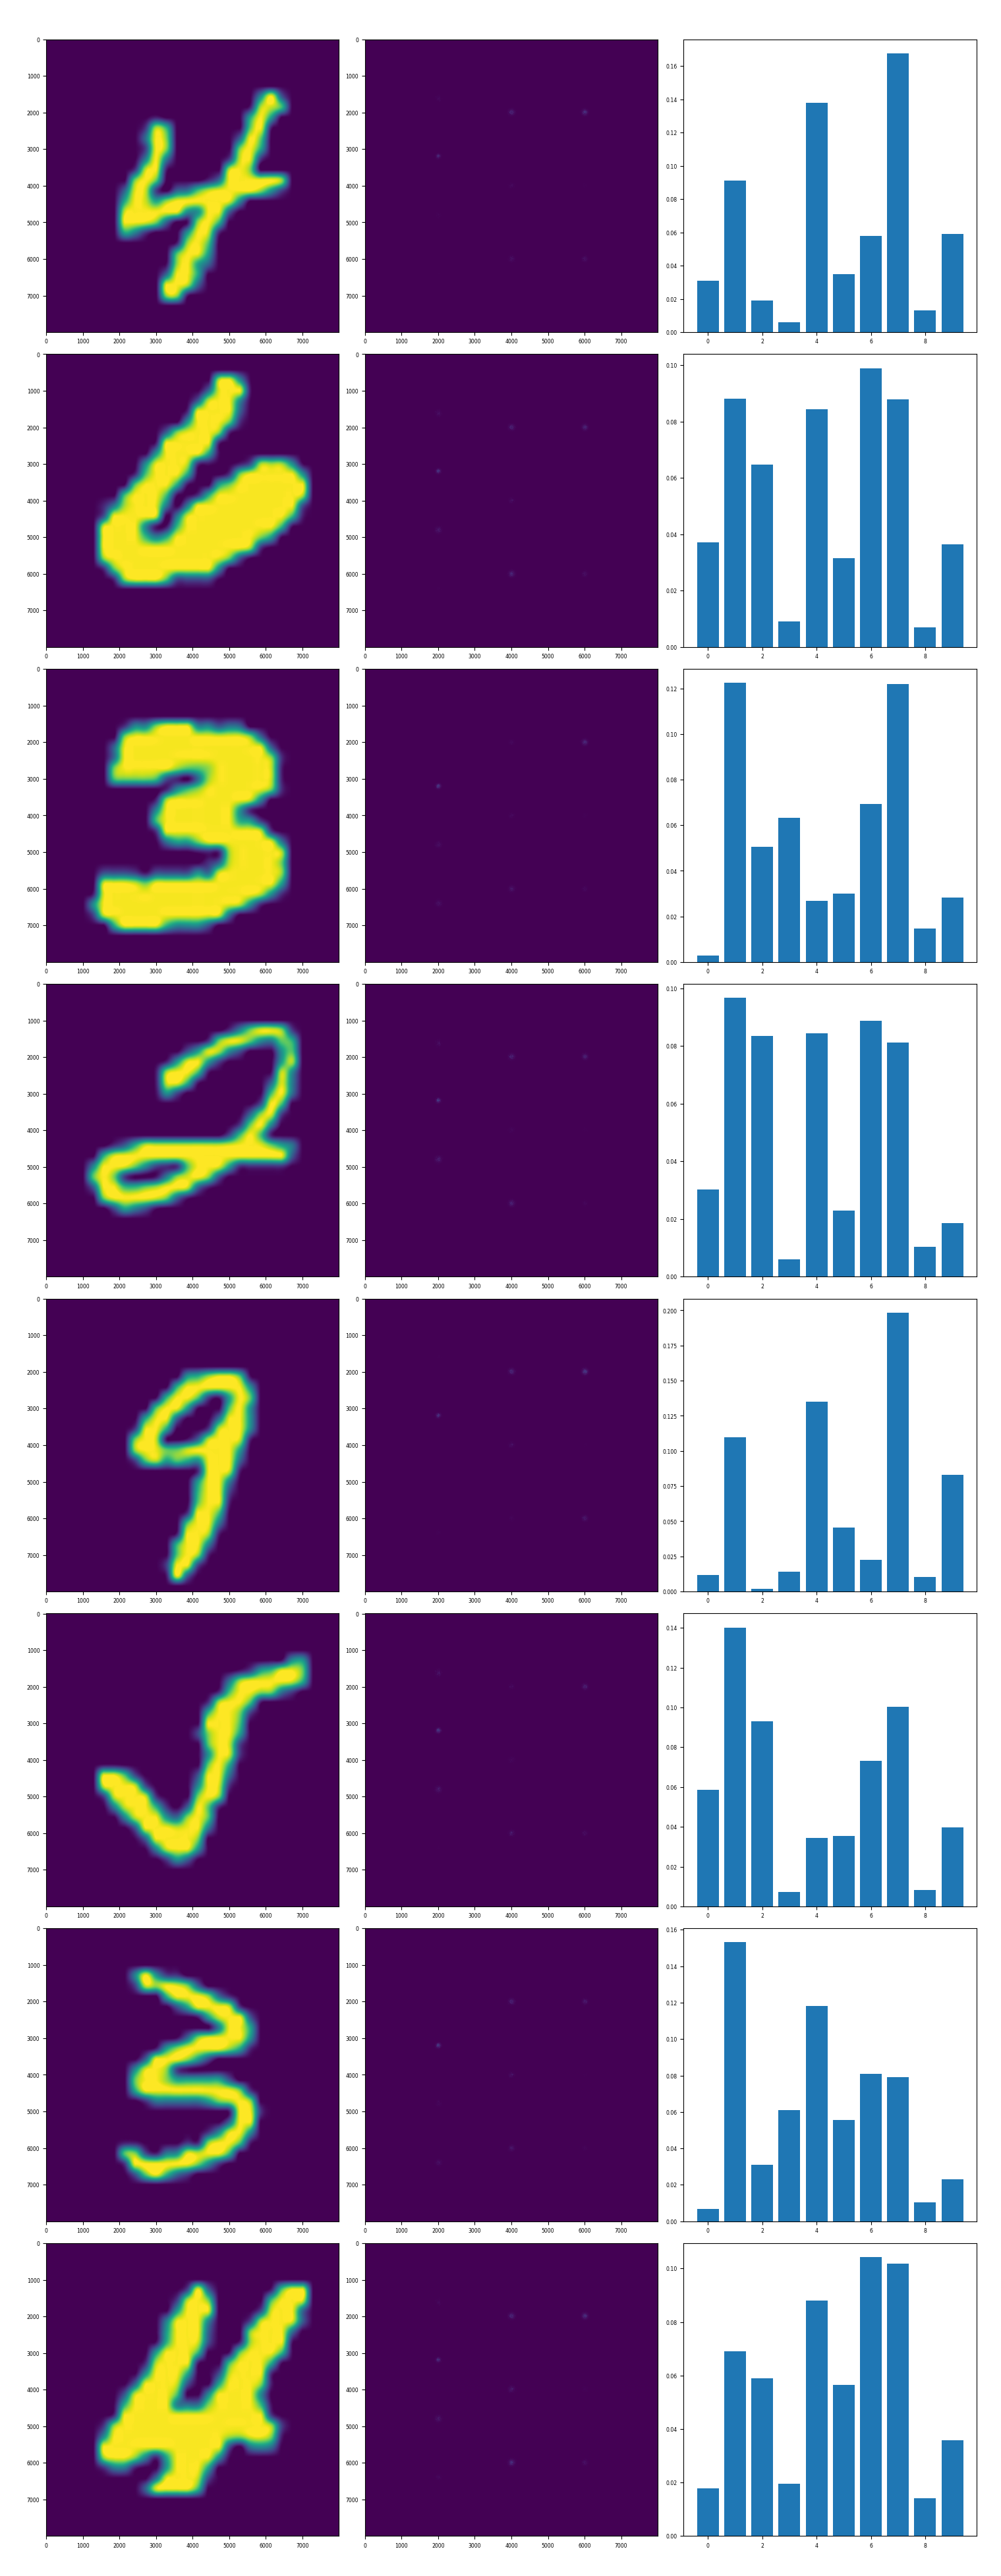

In [17]:
plot = TiledPlot(15,60)
plot.FontLibrary = FontLibrary

for row, (image, optical, detector) in enumerate(zip(examples_images, examples_optical_results, examples_detectors_results)):
    axes = plot.axes.add(0,row)
    axes.imshow(image[0][0], aspect='auto')

    axes = plot.axes.add(1,row)
    axes.imshow(optical[0][0].abs(), aspect='auto')

    axes = plot.axes.add(2,row)
    axes.bar(numpy.arange(10), detector[0])
plot.show()

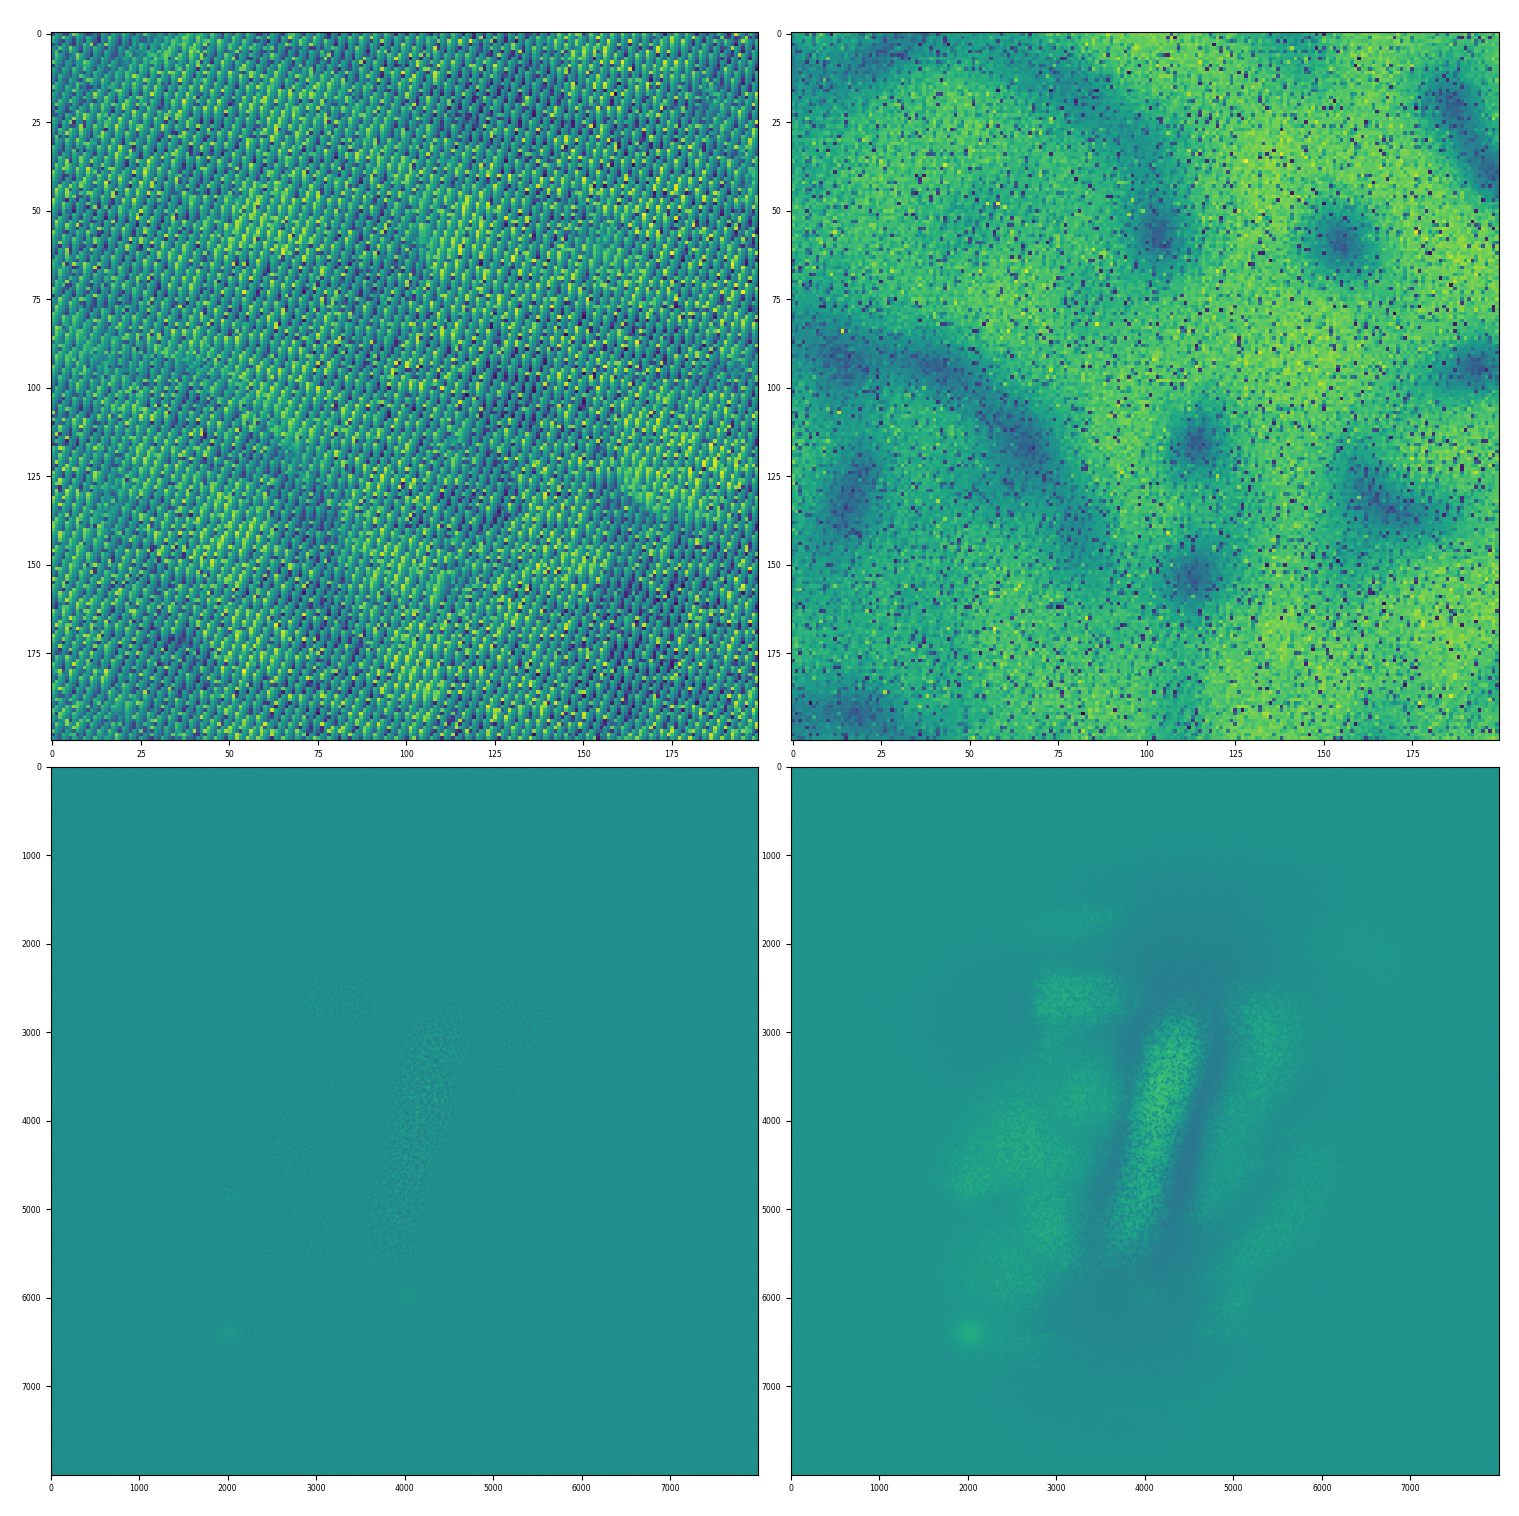

In [18]:
plot = TiledPlot(15,15)
plot.FontLibrary = FontLibrary
axes = plot.axes.add(0,0)
axes.imshow(model.element(2).properties[pixels//2-100:-pixels//2+100, pixels//2-100:-pixels//2+100], aspect='auto')
axes = plot.axes.add(1,0)
axes.imshow(model.element(3).properties[pixels//2-100:-pixels//2+100, pixels//2-100:-pixels//2+100], aspect='auto')
axes = plot.axes.add(0,1)
axes.imshow(model.element(2).properties, aspect='auto')
axes = plot.axes.add(1,1)
axes.imshow(model.element(3).properties, aspect='auto')
plot.show()

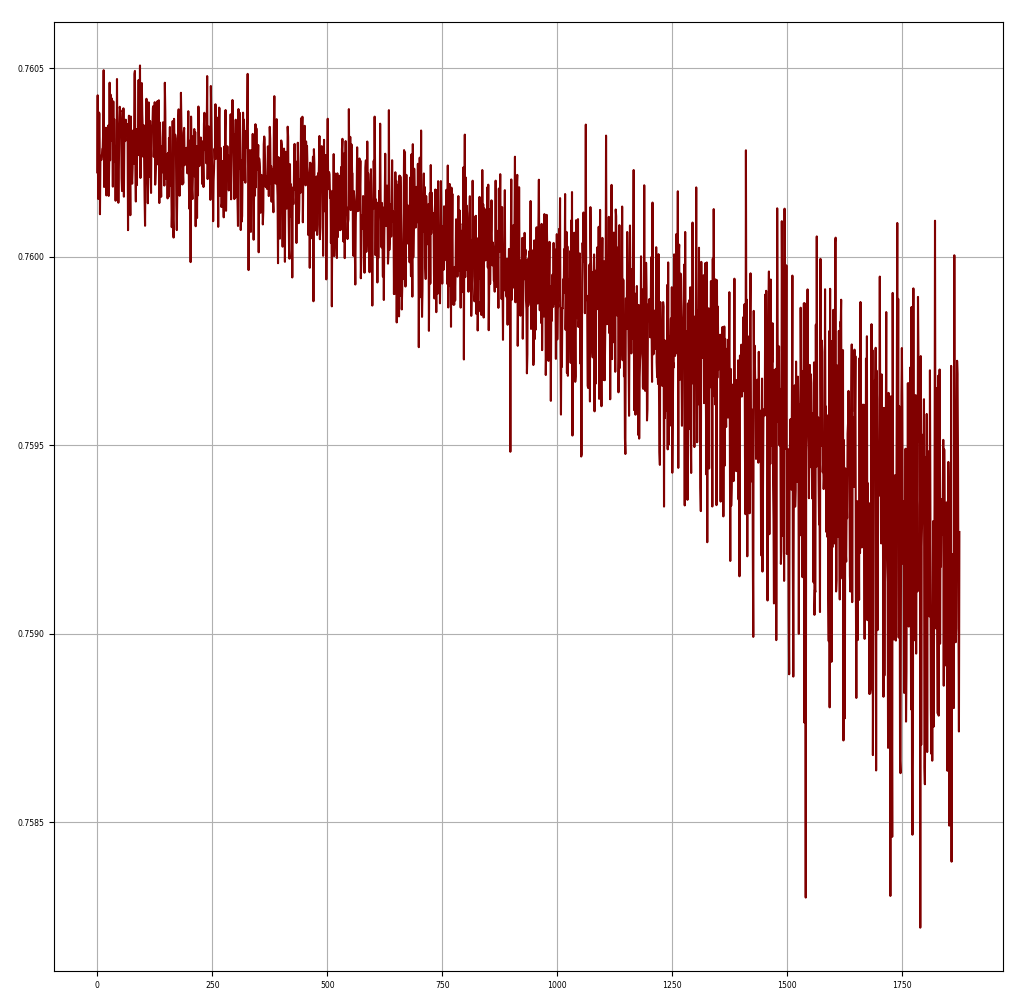

In [19]:
plot = TiledPlot(10,10)
plot.FontLibrary = FontLibrary

axes = plot.axes.add(0,0)
axes.grid(True)
axes.plot(loss_history, c='maroon')

plot.show()

In [21]:
print(examples_detectors_results)
print(f"Accuracy is {100 * numpy.sum(numpy.diagonal(confusion_matrix, 0)) / numpy.sum(confusion_matrix)}")

[tensor([[0.0308, 0.0910, 0.0192, 0.0062, 0.1381, 0.0347, 0.0579, 0.1677, 0.0132,
         0.0590]]), tensor([[0.0371, 0.0882, 0.0647, 0.0091, 0.0843, 0.0314, 0.0989, 0.0879, 0.0069,
         0.0365]]), tensor([[0.0028, 0.1225, 0.0505, 0.0632, 0.0268, 0.0299, 0.0693, 0.1221, 0.0146,
         0.0284]]), tensor([[0.0303, 0.0967, 0.0834, 0.0060, 0.0843, 0.0229, 0.0888, 0.0813, 0.0104,
         0.0187]]), tensor([[0.0117, 0.1099, 0.0018, 0.0143, 0.1351, 0.0455, 0.0225, 0.1984, 0.0106,
         0.0833]]), tensor([[0.0586, 0.1402, 0.0930, 0.0072, 0.0343, 0.0354, 0.0733, 0.1004, 0.0083,
         0.0397]]), tensor([[0.0066, 0.1531, 0.0312, 0.0611, 0.1180, 0.0555, 0.0809, 0.0792, 0.0104,
         0.0231]]), tensor([[0.0179, 0.0691, 0.0591, 0.0196, 0.0879, 0.0564, 0.1042, 0.1019, 0.0142,
         0.0357]])]
Accuracy is 28.640488607721956


# Тренировка с помощью Optuna

In [ ]:
# def objective(trial:optuna.trial):
#     propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, 0.4)
#     phase_modulators = [PhaseModulator(N, length, pixels) for i in range(masks_amount)]
#     amplitude_modulators = [AmplitudeModulator(N, length, pixels) for i in range(masks_amount)]
#     elements = [propagation]
#     for phase_modulator, amplitude_modulator in zip(phase_modulators, amplitude_modulators):
#         elements += [phase_modulator, amplitude_modulator, propagation]
#     spectral_filter = Window(centers=wavelength, sizes=300.0E-9)
#     detectors_filter = Gaussian((length/10, length/10), (0,0))
#     detectors = ClassificationDetectors(N, length, wavelength, 10, detectors_filter, spectral_filter)
#     elements.append(detectors)
#     model = CompositeModel(*elements)
#     dataset = Dataset('MNIST', batch_size, N, N, torch.float32, threads=8, preload=10)